### Anomaly Detection of Solar Flares from RHESSI Satellite

### Section 1: Introduction

The project here is aimed at detecting anomalous solar flares detected between 2002 and 2016. The identifying features are explored in the next section to determine cutoffs for anomalous events that do not follow the trend between duration of solar flares and counts of the flares. After exploration, I noticed the Pearson Correlation function would show anomalous relations in the lower quartile range as seen below. I am expecting slightly differemt losses between trained and test data because the anomalies are not as apparent and that is why I think the unsupervised machine learning algorithm is better suited to show the difference in losses to determine anomaly

In [1]:
import pandas as pd

import torch
import torchvision
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision import datasets
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
sc = StandardScaler()

import sys
import time
import numpy as np

In [2]:
df = pd.read_csv('/Users/shashank/Documents/archive/hessi.solar.flare.2002to2016.csv')

### Having a look at the Solar Flare data and which columns have integers or floats to use 

In [3]:
df.head()

,flare,start.date,start.time,peak,end,duration.s,peak.c/s,total.counts,energy.kev,x.pos.asec,y.pos.asec,radial,active.region.ar,flag.1,flag.2,flag.3,flag.4,flag.5
0,2021213,2002-02-12,21:29:56,21:33:38,21:41:48,712,136,167304,12-25,592,-358,692,0,A1,P1,NaN,NaN,NaN
1,2021228,2002-02-12,21:44:08,21:45:06,21:48:56,288,7,9504,6-12,604,-341,694,9811,A1,P1,PE,Q1,NaN
2,2021332,2002-02-13,00:53:24,00:54:54,00:57:00,216,15,11448,6-12,-310,375,487,9825,A1,P1,NaN,NaN,NaN
3,2021308,2002-02-13,04:22:52,04:23:50,04:26:56,244,20,17400,12-25,-277,378,469,9822,A1,P1,NaN,NaN,NaN
4,2021310,2002-02-13,07:03:52,07:05:14,07:07:48,236,336,313392,25-50,-272,390,476,9825,A1,GS,P1,PE,Q2


### Section 2: Data

As described,  I am splitting the dataframe into appropriate numpy arrays for plotting and also creating train data which is mostly regular and test data that contains the anomalies

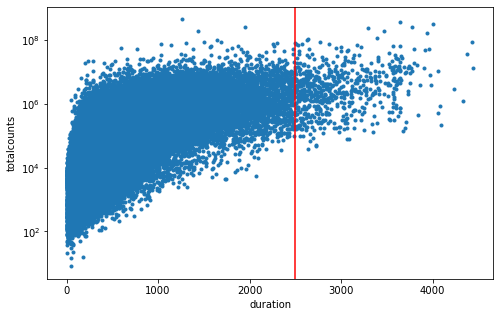

In [21]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.plot(np.array(df[['duration.s']]), np.array(df[['total.counts']]), '.')
plt.xlabel('duration')
plt.ylabel('totalcounts')
plt.axvline(x = 2.5e+3, color = 'r')
plt.yscale('log')

The outlying datapoints beyond the vertical threshold is also seemingly anomalous. I am taking advantage of the unsuperivised nature of the autoencoder to train for both types of anomalies.

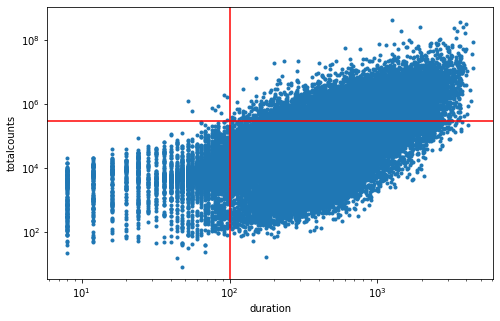

In [22]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.plot(np.array(df[['duration.s']]), np.array(df[['total.counts']]), '.')
plt.xlabel('duration')
plt.ylabel('totalcounts')
plt.axvline(x = 1e+2, color = 'r')
plt.axhline(y = 3e+5, color = 'r')
plt.yscale('log')
plt.xscale('log')

The vertical and horizontal lines below separate anomalous data from the rest of the correlated data

In [30]:
flares_float = df[['flare','duration.s','peak.c/s','total.counts','x.pos.asec','y.pos.asec', 'radial', 'active.region.ar']]
flares = torch.tensor(flares_float.values) 

#
#test dataframe only consists of anamolous data points according to the total counts 
#See plot below, with the horizontal line 
flares_test  = flares_float.loc[(flares_float['total.counts'] <= 3e+5) & (flares_float['duration.s'] <= 1e+2)]
flares_remainder = flares_float.drop(flares_test.index)
n_train = 9000
flares_train = flares_remainder.sample(n=n_train, random_state = 123)

#normalizing the data sets
flares_train = sc.fit_transform(flares_train)                     
flares_test  = sc.fit_transform(flares_test)
#converting to tensors with float values
flares_train = torch.tensor(flares_train, dtype = torch.float)
flares_test  = torch.tensor(flares_test, dtype = torch.float)
#making sure the tensors are both half of the full dataset
print ('-------------------------------------------------------')
print (f'size of the whole dataframe : {flares.size()}')
print (f'size of the training data   : {flares_train.size()}')
print (f'size of the test data       : {flares_test.size()}')
print ('-------------------------------------------------------')

-------------------------------------------------------
size of the whole dataframe : torch.Size([113942, 8])
size of the training data   : torch.Size([9000, 8])
size of the test data       : torch.Size([7855, 8])
-------------------------------------------------------


### Section 3 & 4: Network and Parameters

My Autoencoder has a hidden layer between input and output layers, with more hidden nodes to make an overcomplete autoencoder. The whole dataframe is being passed to I have 8 input nodes and I have shown above that duration and totalcounts features are 2 feature parameters that the frame can be reduced in dimension to while still containing complete information.

In [32]:
class AutoEncoder(nn.Module):
    def __init__(self,n,d):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(n, 15),  
            torch.nn.ReLU(),
            torch.nn.Linear(15, 5), #hidden layer has larger hidden nodes for overcomplete autoencoder 
            torch.nn.ReLU(),
            torch.nn.Linear(5, d)
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(d, 5),
            torch.nn.ReLU(),
            torch.nn.Linear(5, 15),
            torch.nn.ReLU(),
            torch.nn.Linear(15, n),
            torch.nn.Sigmoid()  #sigmoid because the values have to be positive when outputs is returned (duration and counts can't be negative) 
        )
 
    #no particular activation functions used here as they interfere with the smooth rate of decline of losses
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

#output is 2 because I think duration and total counts are 
#the only two useful parameters (the most supervision I do for this unsupervised ML AE)
net=AutoEncoder(8,2)  
torch.save(net.state_dict(), 'ae.pth')

The MSE loss makes most sense because the hope is that there is a function to map the two parameters while anomalous ones will produce high losses because they are outliers. The learning rate is the standard choice for Adam optimizer before testing which hyperparameter works best. 

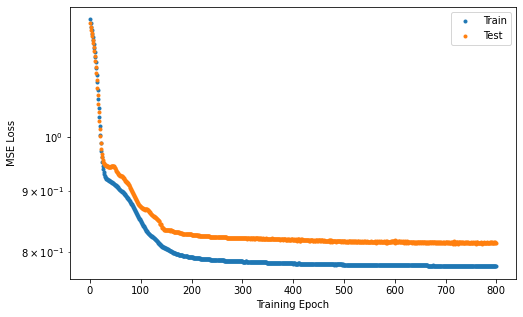

In [33]:
torch.manual_seed(123)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

losses_train = []
losses_test=[]
net.load_state_dict(torch.load('ae.pth'))

for epoch in range(800):
    net.train() 
    flares_pred = net(flares_train)
    loss = loss_fn(flares_pred, flares_train)
    optimizer.zero_grad()
    loss.backward()       
    optimizer.step()      
    losses_train.append(loss.data)
    net.eval()
    losses_test.append(loss_fn(net(flares_test),flares_test).data)

plt.plot(losses_train, '.', label='Train')
plt.plot(losses_test,'.',label="Test")
plt.legend()
plt.xlabel('Training Epoch')
plt.ylabel('MSE Loss')
plt.yscale('log');
plt.legend();

Currently, the losses level out after sufficient epochs, I will subsequently test if the losses reduce even further with larger epochs

### Section 5: Execution

The helper function below samples the losses for each dataset to be better visualized in a histogram plot as seen below

In [34]:
net.eval()
def getLosses(sample):
    losses=[]
    for i in range(len(sample)):
        pred = net(sample[i])
        loss = loss_fn(pred, sample[i])
        losses.append(loss.data.item())
    return losses

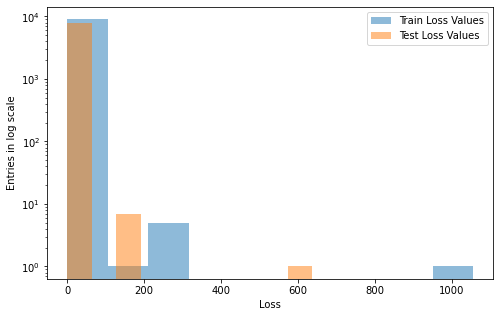

In [35]:
lossvalues_train = getLosses(flares_train)
lossvalues_test  = getLosses(flares_test)
plt.hist(lossvalues_train, alpha = 0.5, label = 'Train Loss Values')
plt.hist(lossvalues_test, alpha = 0.5, label = 'Test Loss Values')
plt.xlabel('Loss')
plt.ylabel('Entries in log scale')
plt.yscale('log')
plt.legend()

The losses are very similar to each other with a very features to show that there is a disparity between the test and train losses as seen above

### Section 7: Optimization 

I assume the maximization of the anomaly score is how the hyperparameters are optimized

Train Dataset Loss after training with lr 0.01: 0.776724100112915
Test Dataset Loss after training with lr 0.01: 0.8119971752166748
------------------------------------------------------------------------------------
Train Dataset Loss after training with lr 0.02: 0.7706725001335144
Test Dataset Loss after training with lr 0.02: 0.8272168636322021
------------------------------------------------------------------------------------
Train Dataset Loss after training with lr 0.03: 0.7813807725906372
Test Dataset Loss after training with lr 0.03: 0.8237040638923645
------------------------------------------------------------------------------------
Train Dataset Loss after training with lr 0.04: 0.7737904787063599
Test Dataset Loss after training with lr 0.04: 0.8107147812843323
------------------------------------------------------------------------------------
Train Dataset Loss after training with lr 0.05: 0.7827375531196594
Test Dataset Loss after training with lr 0.05: 0.8123720884323

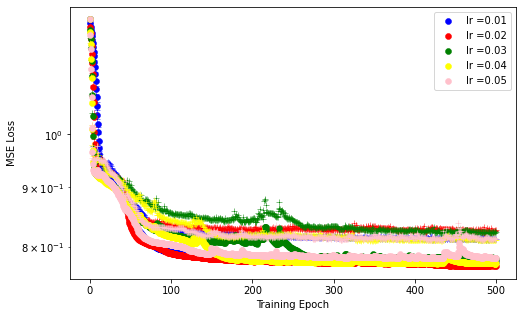

In [36]:
torch.manual_seed(123)
learning_rate = [0.01, 0.02, 0.03, 0.04, 0.05]
colors = ['b', 'r', 'g', 'yellow', 'pink']
for i in range(0, 5):
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate[i])
    

    losses_train = []
    losses_test=[]
    net.load_state_dict(torch.load('ae.pth'))

    for epoch in range(1000):
        net.train() 
        flares_pred = net(flares_train)
        loss = loss_fn(flares_pred, flares_train)
        optimizer.zero_grad()
        loss.backward()       
        optimizer.step()      
        losses_train.append(loss.data)
        net.eval()
        losses_test.append(loss_fn(net(flares_test),flares_test).data)
    
    epochs = np.linspace(0, 500, len(losses_train))
    plt.scatter(epochs, losses_train, color = colors[i], marker = 'o', linewidth = 0.5, label = f'lr ={learning_rate[i]}')
    plt.scatter(epochs, losses_test, color = colors[i], marker  = '+', linewidth = 0.5)
    plt.xlabel('Training Epoch')
    plt.ylabel('MSE Loss')
    plt.yscale('log')
    plt.legend()
    print (f'Train Dataset Loss after training with lr {learning_rate[i]}: {losses_train[-1]}')
    print (f'Test Dataset Loss after training with lr {learning_rate[i]}: {losses_test[-1]}')
    print ('------------------------------------------------------------------------------------')

The lowest losses after the same number of epochs is with the 0.02 learning rate, now I can test the epochs

In [37]:
torch.manual_seed(123)
epochs = [700, 800, 900, 1000, 1100]
colors = ['b', 'r', 'g', 'yellow', 'pink', 'black', 'purple', 'magenta']
for i in range(0, 5):
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.02)
    
    losses_train = []
    losses_test=[]
    mega_losses_train = []
    mega_losses_test  = []
    net.load_state_dict(torch.load('ae.pth'))

    for epoch in range(epochs[i]):
        net.train() 
        flares_pred = net(flares_train)
        loss = loss_fn(flares_pred, flares_train)
        optimizer.zero_grad()
        loss.backward()       
        optimizer.step()      
        losses_train.append(loss.data)
        net.eval()
        losses_test.append(loss_fn(net(flares_test),flares_test).data)

    print (f'Train Dataset Loss after training with lr {epochs[i]}: {losses_train[-1]}')
    print (f'Test Dataset Loss after training with lr {epochs[i]}: {losses_test[-1]}')
    print ('------------------------------------------------------------------------------------')

Train Dataset Loss after training with lr 700: 0.7749632000923157
Test Dataset Loss after training with lr 700: 0.8299733400344849
------------------------------------------------------------------------------------
Train Dataset Loss after training with lr 800: 0.7731006741523743
Test Dataset Loss after training with lr 800: 0.8271124362945557
------------------------------------------------------------------------------------
Train Dataset Loss after training with lr 900: 0.7707359194755554
Test Dataset Loss after training with lr 900: 0.8261684775352478
------------------------------------------------------------------------------------
Train Dataset Loss after training with lr 1000: 0.7706725001335144
Test Dataset Loss after training with lr 1000: 0.8272168636322021
------------------------------------------------------------------------------------
Train Dataset Loss after training with lr 1100: 0.7687036991119385
Test Dataset Loss after training with lr 1100: 0.8229373097419739
-

Similarly, the losses increase after 1100 epochs, so 1100 epochs is the best epoch option

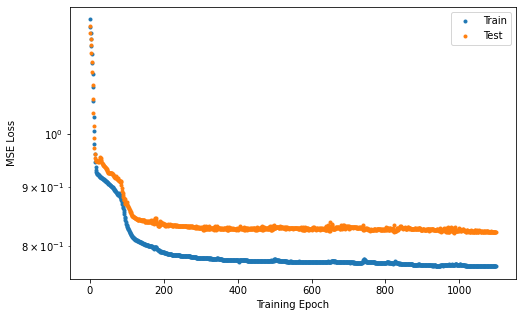

In [38]:
torch.manual_seed(123)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.02)

losses_train = []
losses_test=[]
net.load_state_dict(torch.load('ae.pth'))

for epoch in range(1100):
    net.train() 
    flares_pred = net(flares_train)
    loss = loss_fn(flares_pred, flares_train)
    optimizer.zero_grad()
    loss.backward()       
    optimizer.step()      
    losses_train.append(loss.data)
    net.eval()
    losses_test.append(loss_fn(net(flares_test),flares_test).data)

plt.plot(losses_train, '.', label='Train')
plt.plot(losses_test,'.',label="Test")
plt.legend()
plt.xlabel('Training Epoch')
plt.ylabel('MSE Loss')
plt.yscale('log');
plt.legend();

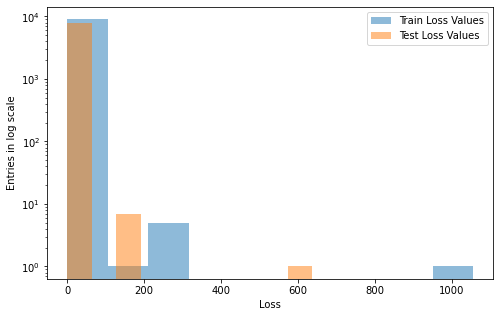

In [39]:
net.eval()
def getLosses(sample):
    losses=[]
    for i in range(len(sample)):
        pred = net(sample[i])
        loss = loss_fn(pred, sample[i])
        losses.append(loss.data.item())
    return losses

lossvalues_train = getLosses(flares_train)
lossvalues_test  = getLosses(flares_test)
plt.hist(lossvalues_train, alpha = 0.5, label = 'Train Loss Values')
plt.hist(lossvalues_test, alpha = 0.5, label = 'Test Loss Values')
plt.xlabel('Loss')
plt.ylabel('Entries in log scale')
plt.yscale('log')
plt.legend()